# Spleen 3D segmentation with MONAI

This tutorial shows how to run SageMaker managed training using MONAI for 3D Segmentation.

This notebook and train.py script in source folder were derived from [this notebook](https://github.com/Project-MONAI/tutorials/blob/master/3d_segmentation/spleen_segmentation_3d.ipynb)

Key features demonstrated here:
1. SageMaker managed training with S3 integration
2. SageMaker hosted inference 

The Spleen dataset can be downloaded from https://registry.opendata.aws/msd/.

![spleen](http://medicaldecathlon.com/img/spleen0.png)

Target: Spleen  
Modality: CT  
Size: 61 3D volumes (41 Training + 20 Testing)  
Source: Memorial Sloan Kettering Cancer Center  
Challenge: Large ranging foreground size
    

### install and import monai libraries 

In [1]:
!pip install  "monai[all]==0.8.0"

     |████████████████████████████████| 709 kB 24.2 MB/s            
     |████████████████████████████████| 297 kB 73.3 MB/s            
     |████████████████████████████████| 125 kB 76.1 MB/s            
     |████████████████████████████████| 148 kB 68.1 MB/s            
     |████████████████████████████████| 316 kB 74.8 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 15.6 MB 60.8 MB/s            
     |████████████████████████████████| 17.9 MB 47.3 MB/s            
     |████████████████████████████████| 232 kB 69.0 MB/s            
     |████████████████████████████████| 5.8 MB 48.0 MB/s            
     |████████████████████████████████| 4.0 MB 28.9 MB/s            
     |████████████████████████████████| 8.5 MB 68.9 MB/s            
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     |████████████████████████████████| 3.3 MB 36.8 MB/s       

In [2]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

MLflow support for Python 3.6 is deprecated and will be dropped in an upcoming release. At that point, existing Python 3.6 workflows that use MLflow will continue to work without modification, but Python 3.6 users will no longer get access to the latest MLflow features and bugfixes. We recommend that you upgrade to Python 3.7 or newer.


In [3]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    EnsureTyped,
    EnsureType,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

import sagemaker 
from sagemaker import get_execution_role


role = get_execution_role()
sess = sagemaker.Session()
region = sess.boto_session.region_name
bucket = sess.default_bucket()

MLflow support for Python 3.6 is deprecated and will be dropped in an upcoming release. At that point, existing Python 3.6 workflows that use MLflow will continue to work without modification, but Python 3.6 users will no longer get access to the latest MLflow features and bugfixes. We recommend that you upgrade to Python 3.7 or newer.


## Prepare the dataset: Spleen dataset
+ Download the Spleen dataset if it is not available locally
+ Transform the images using Compose 
+ Visualize the image 

In [4]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"
compressed_file = "./Task09_Spleen.tar"

MONAILabelServerIP = "../Spleen3D" ## IP address of the MONAI Label Server if deployed
data_dir = MONAILabelServerIP 

if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, data_dir+'/datasets', md5)

In [5]:
## transform the images 
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),  ## keys include image and label with image first
        EnsureChannelFirstd(keys=["image", "label"]),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        EnsureTyped(keys=["image", "label"]),
    ]
)

image shape: torch.Size([226, 157, 113]), label shape: torch.Size([226, 157, 113])


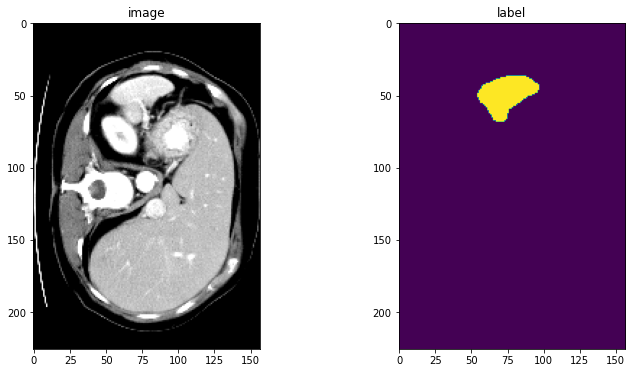

In [6]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "datasets/Task09_Spleen/imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "datasets/Task09_Spleen/labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

## Model training 

+ Divide the dataset into training and testing
+ Upload the dataset into S3 
+ SageMaker training job

In [8]:
from monai.apps import download_and_extract
import os
import glob

train_images = sorted(
    glob.glob(os.path.join(data_dir, "datasets/Task09_Spleen/imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "datasets/Task09_Spleen/labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-1], data_dicts[-1:]

In [ ]:
## copy dataset for training 
!mkdir -p ../Spleen3D/train/imagesTr
!mkdir -p ../Spleen3D/train/labelsTr

## folder for testing dataset
!mkdir -p ../Spleen3D/test/imagesTr
!mkdir -p ../Spleen3D/test/labelsTr

In [9]:
## copy dataset for training 
for file in train_files:
    image = file['image']
    image_dest = "../Spleen3D/train/imagesTr"
    label = file['label']
    label_dest = "../Spleen3D/train/labelsTr"
    shutil.copy(image,image_dest)
    shutil.copy(label,label_dest)

In [10]:
## copy dataset for testing  
for file in val_files:
    image = file['image']
    image_dest = "../Spleen3D/test/imagesTr"
    label = file['label']
    label_dest = "../Spleen3D/test/labelsTr"
    shutil.copy(image,image_dest)
    shutil.copy(label,label_dest)

In [98]:
## upload the dataset to S3
prefix="MONAI-Segmentation"
bucket = sess.default_bucket()
## upload training dataset
S3_inputs = sess.upload_data(
    path="../Spleen3D/train",
    key_prefix=prefix+"/train",
    bucket=bucket 
)

## upload testing dataset
S3_test = sess.upload_data(
    path="../Spleen3D/test",
    key_prefix=prefix+"/test",
    bucket=bucket 
)


S3_inputs

### SageMaker training job

In [ ]:
%time 
import sagemaker
from sagemaker.inputs import FileSystemInput
from sagemaker.pytorch import PyTorch

metrics=[
   {'Name': 'train:average epoch loss', 'Regex': 'average loss: ([0-9\\.]*)'},
   {'Name': 'train:current mean dice', 'Regex': 'current mean dice: ([0-9\\.]*)'},
   {'Name': 'train:best mean dice', 'Regex': 'best mean dice: ([0-9\\.]*)'}
]

estimator = PyTorch(source_dir='code',
                    entry_point='train.py',
                    role=role,
                    framework_version='1.6.0',
                    py_version='py3',
                    instance_count=1,
                    instance_type='ml.p2.xlarge',
                    hyperparameters={
                       "seed": 123,
                       "lr": 0.001,
                       "epochs": 200
                    },
                    metric_definitions=metrics,
#                     ### spot instance training ###
#                    use_spot_instances=True,
#                     max_run=2400,
#                     max_wait=2400
                )


estimator.fit(S3_inputs)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs
2022-04-21 13:02:28 Starting - Starting the training job...
2022-04-21 13:02:56 Starting - Preparing the instances for trainingProfilerReport-1650546148: InProgress
............
2022-04-21 13:04:49 Downloading - Downloading input data....----------
epoch 1/200
1/15, train_loss: 0.6410
2/15, train_loss: 0.6287
3/15, train_loss: 0.6169
4/15, train_loss: 0.6232
5/15, train_loss: 0.5994
6/15, train_loss: 0.6241
7/15, train_loss: 0.6263
8/15, train_loss: 0.5883
9/15, train_loss: 0.6068
10/15, train_loss: 0.5736
11/15, train_loss: 0.5510
12/15, train_loss: 0.5569
13/15, train_loss: 0.5664
14/15, train_loss: 0.5787
15/15, train_loss: 0.5567
16/15, train_loss: 0.5926
epoch 1 average loss: 0.5957
----------
epoch 2/200
1/15, train_loss: 0.5653
2/15, train_loss: 0.5613
3/15, train_loss: 0.5583
4/15, train_loss: 0.5887
5/15, train_loss: 0.5586
6/15, train_loss: 0.5041
7/15, train_loss: 0.5652
8/15, train_loss: 0.5461
9/15, train_loss

13/15, train_loss: 0.3132
14/15, train_loss: 0.1396
15/15, train_loss: 0.3451
16/15, train_loss: 0.0584
epoch 12 average loss: 0.2639
saved new best metric model
Saving the model.
current epoch: 12 current mean dice: 0.3236
best mean dice: 0.3236 at epoch: 12
----------
epoch 13/200
1/15, train_loss: 0.3257
2/15, train_loss: 0.2396
3/15, train_loss: 0.3161
4/15, train_loss: 0.3504
5/15, train_loss: 0.3677
6/15, train_loss: 0.3081
7/15, train_loss: 0.2700
8/15, train_loss: 0.1725
9/15, train_loss: 0.2068
10/15, train_loss: 0.2867
11/15, train_loss: 0.1968
12/15, train_loss: 0.4486
13/15, train_loss: 0.2267
14/15, train_loss: 0.2109
15/15, train_loss: 0.2981
16/15, train_loss: 0.3915
epoch 13 average loss: 0.2885
----------
epoch 14/200
1/15, train_loss: 0.2231
2/15, train_loss: 0.1295
3/15, train_loss: 0.2724
4/15, train_loss: 0.3318
5/15, train_loss: 0.2026
6/15, train_loss: 0.3038
7/15, train_loss: 0.2243
8/15, train_loss: 0.2491
9/15, train_loss: 0.1302
10/15, train_loss: 0.0847
11/1

1/15, train_loss: 0.3279
2/15, train_loss: 0.1607
3/15, train_loss: 0.1804
4/15, train_loss: 0.1475
5/15, train_loss: 0.0429
6/15, train_loss: 0.2511
7/15, train_loss: 0.2181
8/15, train_loss: 0.1278
9/15, train_loss: 0.1672
10/15, train_loss: 0.1628
11/15, train_loss: 0.1040
12/15, train_loss: 0.3223
13/15, train_loss: 0.2735
14/15, train_loss: 0.2118
15/15, train_loss: 0.3307
16/15, train_loss: 0.3026
epoch 28 average loss: 0.2082
current epoch: 28 current mean dice: 0.5064
best mean dice: 0.7961 at epoch: 24
----------
epoch 29/200
1/15, train_loss: 0.3257
2/15, train_loss: 0.2357
3/15, train_loss: 0.1854
4/15, train_loss: 0.3284
5/15, train_loss: 0.3279
6/15, train_loss: 0.2683
7/15, train_loss: 0.2175
8/15, train_loss: 0.2178
9/15, train_loss: 0.1540
10/15, train_loss: 0.2110
11/15, train_loss: 0.2091
12/15, train_loss: 0.2171
13/15, train_loss: 0.4140
14/15, train_loss: 0.1488
15/15, train_loss: 0.1636
16/15, train_loss: 0.0273
epoch 29 average loss: 0.2282
----------
epoch 30/20

9/15, train_loss: 0.2573
10/15, train_loss: 0.2123
11/15, train_loss: 0.0867
12/15, train_loss: 0.1577
13/15, train_loss: 0.1570
14/15, train_loss: 0.1670
15/15, train_loss: 0.0912
16/15, train_loss: 0.3482
epoch 40 average loss: 0.1926
current epoch: 40 current mean dice: 0.4144
best mean dice: 0.7961 at epoch: 24
----------
epoch 41/200
1/15, train_loss: 0.1465
2/15, train_loss: 0.2097
3/15, train_loss: 0.3777
4/15, train_loss: 0.2785
5/15, train_loss: 0.2072
6/15, train_loss: 0.3301
7/15, train_loss: 0.2277
8/15, train_loss: 0.0861
9/15, train_loss: 0.0865
10/15, train_loss: 0.0841
11/15, train_loss: 0.0457
12/15, train_loss: 0.2075
13/15, train_loss: 0.2040
14/15, train_loss: 0.2715
15/15, train_loss: 0.2473
16/15, train_loss: 0.1458
epoch 41 average loss: 0.1972
----------
epoch 42/200
1/15, train_loss: 0.3346
2/15, train_loss: 0.3264
3/15, train_loss: 0.1431
4/15, train_loss: 0.3984
5/15, train_loss: 0.1534
6/15, train_loss: 0.3347
7/15, train_loss: 0.2745
8/15, train_loss: 0.145

8/15, train_loss: 0.1481
9/15, train_loss: 0.2821
10/15, train_loss: 0.2668
11/15, train_loss: 0.3252
12/15, train_loss: 0.1557
13/15, train_loss: 0.2246
14/15, train_loss: 0.1566
15/15, train_loss: 0.1527
16/15, train_loss: 0.1526
epoch 52 average loss: 0.1999
current epoch: 52 current mean dice: 0.7632
best mean dice: 0.8739 at epoch: 46
----------
epoch 53/200
1/15, train_loss: 0.3192
2/15, train_loss: 0.0827
3/15, train_loss: 0.2014
4/15, train_loss: 0.2639
5/15, train_loss: 0.2652
6/15, train_loss: 0.1449
7/15, train_loss: 0.1448
8/15, train_loss: 0.1616
9/15, train_loss: 0.2055
10/15, train_loss: 0.2123
11/15, train_loss: 0.1618
12/15, train_loss: 0.1454
13/15, train_loss: 0.2057
14/15, train_loss: 0.2162
15/15, train_loss: 0.1512
16/15, train_loss: 0.0422
epoch 53 average loss: 0.1828
----------
epoch 54/200


In [106]:
estimator.__dict__['_current_job_name']

estimator.__dict__['output_path']+estimator.__dict__['_current_job_name']+'/output/model.tar.gz'

's3://sagemaker-us-east-1-741261399688/pytorch-training-2022-04-21-13-02-28-173/output/model.tar.gz'

## Inference 

+ deploy the model with customized inference script
+ inference with testing image in S3
+ visualization the results

In [109]:
model_data=estimator.__dict__['output_path']+estimator.__dict__['_current_job_name']+'/output/model.tar.gz'

#model_data='s3://sagemaker-us-east-1-741261399688/pytorch-training-2022-04-20-07-10-51-935/output/model.tar.gz'

In [110]:
model_data

's3://sagemaker-us-east-1-741261399688/pytorch-training-2022-04-21-13-02-28-173/output/model.tar.gz'

In [119]:
%time

from sagemaker.pytorch.model import PyTorchModel

#model_data="s3://sagemaker-us-east-1-741261399688/pytorch-training-2022-04-19-02-45-48-341/model.tar.gz" ## model artifact from S3
#model_data="s3://sagemaker-us-east-1-741261399688/pytorch-training-2022-04-20-05-32-17-544/output/model.tar.gz"
#model_data=estimator.__dict__['output_path']+estimator.__dict__['_current_job_name']+'/output/model.tar.gz'
model = PyTorchModel(
    entry_point="inference.py", ## inference code with customerization
    source_dir="code",        ## folder with the inference code
    role=role,
    model_data=model_data,
    framework_version="1.5.0",
    py_version="py3",
)


predictor = model.deploy(initial_instance_count = 1, instance_type = 'ml.m5.2xlarge',serializer=sagemaker.serializers.JSONSerializer(),deserializer=sagemaker.deserializers.JSONDeserializer())

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.54 µs
-------!

In [120]:
%timeit
payload={"bucket": 'sagemaker-us-east-1-741261399688',
    "key":"MONAI-Segmentation/test"}
response=predictor.predict(payload)

In [121]:
val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=1)

Loading dataset: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


## Visulaize the result

In [122]:
torch.Tensor(response["pred"])

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

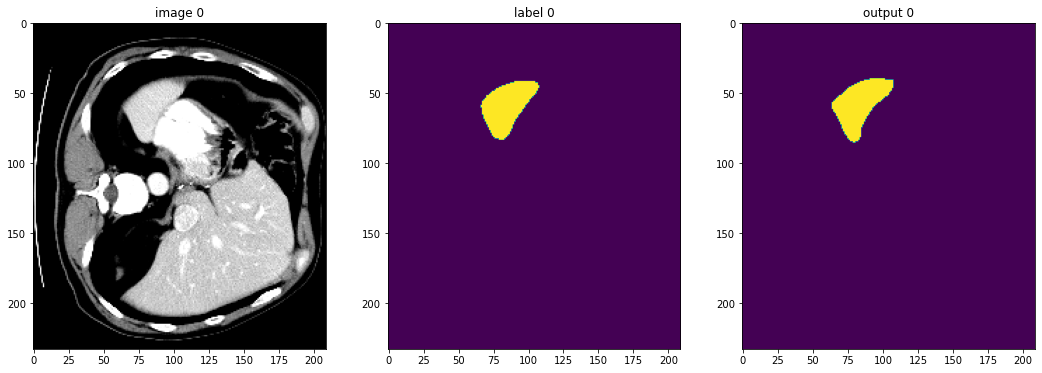

In [123]:
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1,3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.Tensor(response["pred"]))

        plt.show()

## Clean up the resources

+ delete all the endpoints to save cost

import boto3
client = boto3.client('sagemaker')
endpoints=client.list_endpoints()['Endpoints']
endpoints

for endpoint in endpoints:
    response = client.delete_endpoint(
        EndpointName=endpoint['EndpointName']
    )